In [1]:

"""
=========================================================
Gaussian Processes regression: basic introductory example
高斯过程回归：基本介绍性示例
=========================================================

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.

一个简单的一维回归示例以两种不同的方式计算：

1.无噪声的情况
2.每个数据点都具有已知噪声级的噪声情况

在这两种情况下，核参数的估计使用最大似然原理。
图中以点态95%置信区间的形式说明了高斯过程模型的插值性质及其概率性质。
注意，参数alpha作为训练点之间假定协方差的Tikhonov正则化。
"""

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

"\n=========================================================\nGaussian Processes regression: basic introductory example\n高斯过程回归：基本介绍性示例\n=========================================================\n\nA simple one-dimensional regression example computed in two different ways:\n\n1. A noise-free case\n2. A noisy case with known noise-level per datapoint\n\nIn both cases, the kernel's parameters are estimated using the maximum\nlikelihood principle.\n\nThe figures illustrate the interpolating property of the Gaussian Process model\nas well as its probabilistic nature in the form of a pointwise 95% confidence\ninterval.\n\nNote that `alpha` is a parameter to control the strength of the Tikhonov\nregularization on the assumed training points' covariance matrix.\n\n一个简单的一维回归示例以两种不同的方式计算：\n\n无噪声的情况\n每个数据点都具有已知噪声级的噪声情况\n在这两种情况下，核参数的估计使用最大似然原理。\n\n图中以点态95%置信区间的形式说明了高斯过程模型的插值性质及其概率性质。\n\n注意，参数alpha作为训练点之间假定协方差的Tikhonov正则化。\n"

In [2]:
# Dataset generation 数据集生成
# ------------------
#
# We will start by generating a synthetic dataset. The true generative process
# is defined as :math:`f(x) = x \sin(x)`.
#我们将从生成一个合成数据集开始。真正的生成过程
#定义为:math: ' f(x) = x \sin(x) '。
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

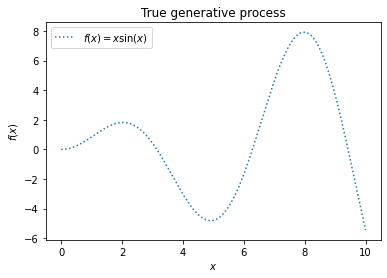

In [3]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [4]:
# We will use this dataset in the next experiment to illustrate how Gaussian
# Process regression is working.
#
# Example with noise-free target
# ------------------------------
#
# In this first example, we will use the true generative process without
# adding any noise. For training the Gaussian Process regression, we will only
# select few samples.
#我们将在接下来的实验中使用这个数据集来说明高斯过程回归是如何工作的。
#无噪声目标的例子
# ------------------------------
#在第一个例子中，我们将使用真正的生成过程而不添加任何杂音。为了训练高斯过程回归，我们将只选择少量的样本。
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [5]:
# Now, we fit a Gaussian process on these few training data samples. We will
# use a radial basis function (RBF) kernel and a constant parameter to fit the
# amplitude.
#现在，我们在这几个训练数据样本上拟合一个高斯过程。我们将使用径向基函数(RBF)核和一个常数参数来拟合振幅。
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

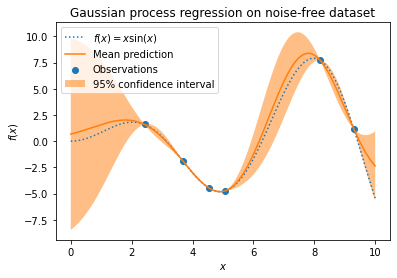

In [6]:
# After fitting our model, we see that the hyperparameters of the kernel have
# been optimized. Now, we will use our kernel to compute the mean prediction
# of the full dataset and plot the 95% confidence interval.
# 在拟合我们的模型之后，我们看到内核的超参数已经被优化了。
# 现在，我们将使用我们的核函数来计算整个数据集的平均预测值，并绘制95%置信区间。
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [7]:
# We see that for a prediction made on a data point close to the one from the
# training set, the 95% confidence has a small amplitude. Whenever a sample
# falls far from training data, our model's prediction is less accurate and the
# model prediction is less precise (higher uncertainty).
#
# Example with noisy targets
# --------------------------
#
# We can repeat a similar experiment adding an additional noise to the target
# this time. It will allow seeing the effect of the noise on the fitted model.
#
# We add some random Gaussian noise to the target with an arbitrary
# standard deviation.
#我们看到，对于一个接近训练集的数据点所做的预测，95%置信有一个小幅度。当样本与训练数据相差甚远时，
# 我们的模型预测就不那么准确，模型预测也不那么准确(更高的不确定性)。
#示例与噪声目标
# --------------------------
#我们可以重复一个类似的实验，这次给目标添加额外的噪声。它将允许看到噪声对拟合模型的影响。
#我们添加一些随机高斯噪声到目标与任意标准偏差。
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [8]:
# We create a similar Gaussian process model. In addition to the kernel, this
# time, we specify the parameter `alpha` which can be interpreted as the
# variance of a Gaussian noise.
#我们创建了一个类似的高斯过程模型。除了核之外，这次我们指定了参数‘alpha’，它可以被解释为高斯噪声的方差
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std ** 2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

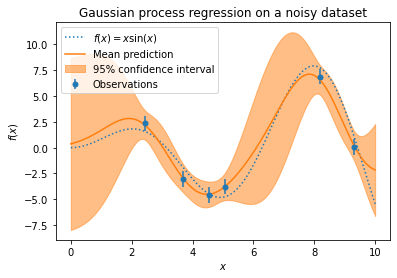

In [9]:
# Let's plot the mean prediction and the uncertainty region as before.
#让我们像之前一样画出平均预测和不确定性区域。
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [10]:
# The noise affects the predictions close to the training samples: the
# predictive uncertainty near to the training samples is larger because we
# explicitly model a given level target noise independent of the input
# variable.
#噪声影响训练样本附近的预测:训练样本附近的预测不确定性更大，
# 因为我们明确地建模一个给定水平的目标噪声独立于输入变量。